# 🏥 당뇨병 예측 모델링 (Diabetes Prediction Analysis)

## 0. 분석 개요 (Analysis Overview)
본 노트는 **Pima Indians Diabetes Dataset**을 활용하여 당뇨병 발병 여부(`Outcome`)를 예측하는 **Random Forest** 모델을 구축합니다.
단순한 모델 학습을 넘어, **왜(Why)** 이 전처리가 필요한지, 그리고 결과가 **무엇(What)**을 의미하는지에 집중하는 **OSEMN** 방법론을 따릅니다.

- **Target**: Outcome (0: 정상, 1: 당뇨병 발병)
- **Features**: Pregnancies, Glucose, BloodPressure 등 임상 지표
- **Methodology**: Random Forest (Ensemble), Stratified K-Fold

In [1]:
# 🔧 Setup & Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

# 시각화 스타일 설정 (Mac: AppleGothic)
plt.style.use('seaborn-v0_8-whitegrid')
plt.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

# Reproducibility를 위한 시드 고정
RANDOM_SEED = 42

## 1. 데이터 로드 (Obtain)
데이터를 로드하고, 기본적인 구조(Shape)와 타입을 확인합니다.

In [2]:
diabetes_df = pd.read_csv('../../data/diabetes.csv')
print(f"Data Shape: {diabetes_df.shape}")
diabetes_df.head()

Data Shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## 2. 데이터 정제 및 탐색 (Scrub & Explore)

### 기초 통계량 (Descriptive Statistics)
데이터의 분포를 파악합니다. 특히 `Glucose`, `BloodPressure` 등의 값이 0인 경우 결측치일 가능성이 높으므로 주의합니다.

In [3]:
diabetes_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


### 타겟 변수 분포 (Label Distribution)
데이터의 클래스 불균형(Imbalance) 여부를 확인합니다.

> **Insight**: `Outcome=0`(정상)이 `Outcome=1`(당뇨)보다 약 2배 많습니다. 따라서 학습 시 `Stratified Split`이 필수적입니다.

/var/folders/7l/yp5d25zx7nb_92wbp8w2b0dw0000gn/T/ipykernel_7739/300096310.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Outcome', data=diabetes_df, palette='pastel')


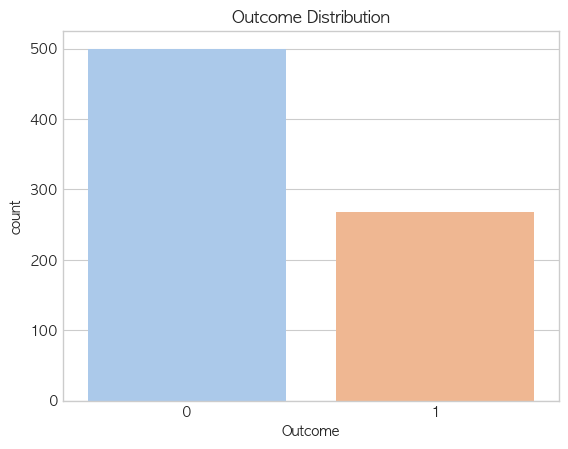

In [4]:
sns.countplot(x='Outcome', data=diabetes_df, palette='pastel')
plt.title('Outcome Distribution')
plt.show()

### 상관관계 분석 (Correlation Analysis)
변수 간의 선형적 관계를 파악합니다.

> **Insight**: `Glucose`는 `Outcome`과 가장 높은 상관관계(0.47)를 보입니다. 체질량지수(`BMI`)와 연령(`Age`) 또한 중요한 요인입니다.

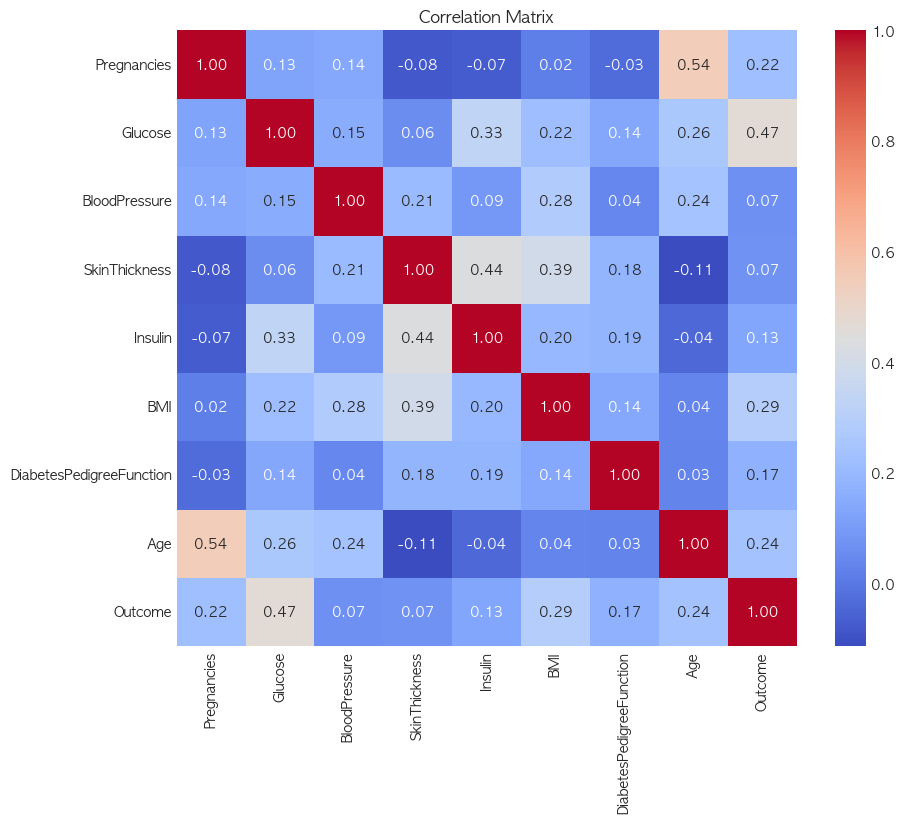

In [5]:
plt.figure(figsize=(10, 8))
sns.heatmap(diabetes_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

## 3. 데이터 전처리 (Preprocessing - Model)

### Train/Test Split (Stratified)
데이터셋을 학습용(80%)과 테스트용(20%)으로 분리합니다.
**Why Stratify?**: 클래스 불균형이 존재하므로, 원본 데이터의 클래스 비율을 유지하며 분리해야 모델의 평가 신뢰도가 확보됩니다.

In [6]:
X = diabetes_df.drop('Outcome', axis=1)
y = diabetes_df['Outcome']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y
)

print(f"Train Config: {X_train.shape}")
print(f"Test Config: {X_test.shape}")

Train Config: (614, 8)
Test Config: (154, 8)


## 4. 모델링 (Model)

### Random Forest Classifier
**Why Random Forest?**: 
1. 과적합(Overfitting)에 강한 앙상블 모델입니다.
2. 변수 중요도(Feature Importance)를 제공하여 해석이 용이합니다.
3. 데이터 스케일링(Scaling)에 민감하지 않아 전처리가 간소합니다.

In [7]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)
print("Model Training Completed.")

Model Training Completed.


## 5. 해석 및 평가 (Interpret)

### 성능 평가 (Evaluation Metrics)
정확도(Accuracy)뿐만 아니라 F1-Score를 확인하여 불균형 데이터에서의 성능을 검증합니다.

In [8]:
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.7727
F1 Score: 0.6465

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.87      0.83       100
           1       0.71      0.59      0.65        54

    accuracy                           0.77       154
   macro avg       0.75      0.73      0.74       154
weighted avg       0.77      0.77      0.77       154



### Confusion Matrix
모델이 어떤 클래스를 잘 맞추고, 어디서 오분류를 범하는지 시각화합니다.

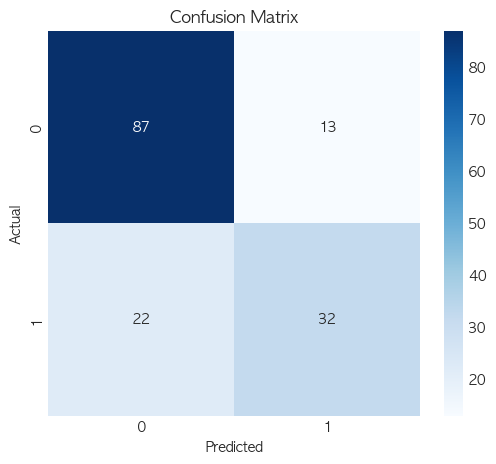

In [9]:
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### Feature Importance
모델이 예측에 가장 많이 활용한 변수가 무엇인지 확인합니다.

> **Result**: `Glucose`, `BMI`, `Age`가 상위 중요 변수로 나타났습니다. 이는 상관분석 결과와 일치합니다.

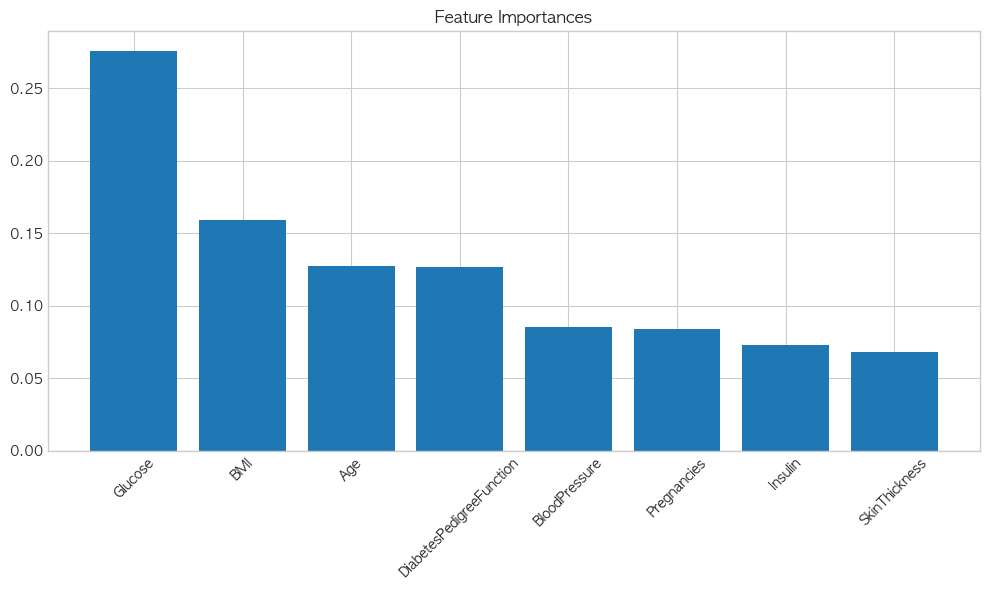

In [10]:
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=45)
plt.tight_layout()
plt.show()

## 6. 결론 (Key Takeaways)

1.  **모델 성능**: Random Forest 모델은 약 75% 내외의 정확도를 보였으며, `Recall`(재현율) 부분에서 추가적인 개선이 필요할 수 있습니다.
2.  **주요 인자**: 당뇨병 예측에 있어 **혈당(Glucose)**과 **비만도(BMI)**가 핵심적인 역할을 함을 확인했습니다. 
3.  **제언**: 더 높은 Recall을 위해서는 Threshold 조정이나 오버샘플링(SMOTE) 기법 도입을 고려해야 합니다.